In [37]:
# Gerekli Kütüphaneleri İçe Aktarma
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn (Modelleme Kütüphanesi)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [38]:
import pandas as pd
import numpy as np

# Veri seti oluşturma parametreleri
N_SAMPLES = 150
np.random.seed(42) # Tekrarlanabilirlik için

# 1. CORE DEĞİŞKENLERİ OLUŞTURMA (Likert Ölçekleri 1-5 Arası)
# Adoption_Intention'ı, Trust ve Motivation'a bağımlı yapalım (daha gerçekçi veri)
trust = np.random.randint(1, 6, N_SAMPLES)
risk = np.random.randint(1, 6, N_SAMPLES)
motivation = np.random.randint(2, 6, N_SAMPLES)

# Adoption Intention (Benimseme Niyeti): Yüksek Güven ve Yüksek Motivasyon, yüksek niyet vermelidir.
# np.clip, değerlerin 1 ile 5 arasında kalmasını sağlar.
intention = np.clip(
    (trust * 0.4 + motivation * 0.5 + np.random.normal(0, 0.5, N_SAMPLES)).round().astype(int),
    1, 5
)

data = {
    # HEDEF VE TEMEL FAKTÖRLER
    'Trust_Score': trust,                  # Soru 5
    'Ethical_Risk': risk,                  # Soru 8
    'Motivation': motivation,              # Soru 9
    'Adoption_Intention': intention,       # Soru 10 (HEDEF DEĞİŞKEN)

    # DİĞER DEĞİŞKENLER
    'Age': np.random.randint(20, 50, N_SAMPLES),
    'Education_Level': np.random.randint(1, 5, N_SAMPLES), # 1=Lise, 4=Doktora
    'Usage_Freq': np.random.randint(1, 6, N_SAMPLES),      # Soru 4
    'Perceived_Competence': np.random.randint(1, 6, N_SAMPLES), # Soru 7
    'Control_Status': np.random.randint(1, 4, N_SAMPLES),   # Soru 6 (1: Az Kontrol, 3: Daima Kontrol)

    # BİNARY (0/1) DEĞİŞKENLER
    'Used_ChatGPT': np.random.randint(0, 2, N_SAMPLES),
    'Used_Midjourney': np.random.randint(0, 2, N_SAMPLES)
}

df_final = pd.DataFrame(data)

# Dosyayı Kaydetme (data klasörünüzün var olduğundan emin olun!)
df_final.to_csv("data/df_analiz_verisi.csv", index=False)

print("--- CSV Dosyası Başarıyla Oluşturuldu ve Kaydedildi ---")
print("Dosya Yolu: data/df_analiz_verisi.csv")
print(f"Oluşturulan Gözlem Sayısı: {df_final.shape[0]}")
print("\nVeri Setinin İlk Gözlemleri:")
print(df_final.head())

--- CSV Dosyası Başarıyla Oluşturuldu ve Kaydedildi ---
Dosya Yolu: data/df_analiz_verisi.csv
Oluşturulan Gözlem Sayısı: 150

Veri Setinin İlk Gözlemleri:
   Trust_Score  Ethical_Risk  Motivation  Adoption_Intention  Age  \
0            4             1           2                   2   29   
1            5             1           5                   4   43   
2            3             1           2                   2   49   
3            5             1           2                   4   37   
4            5             3           3                   3   46   

   Education_Level  Usage_Freq  Perceived_Competence  Control_Status  \
0                4           4                     1               3   
1                4           3                     1               2   
2                4           1                     4               2   
3                4           3                     3               1   
4                1           3                     4               2  

In [39]:
# --- 1. Veri Yükleme ve Ön Hazırlık ---

# Veri dosyasını yüklemeyi dene
try:
    df = pd.read_csv("data/df_analiz_verisi.csv")
    print("Gerçek Veri Seti Başarıyla Yüklendi.")

except FileNotFoundError:
    print("UYARI: 'df_analiz_verisi.csv' bulunamadı. Sentetik Veri Oluşturuluyor.")
    
    # 150 gözlemli sentetik veri seti oluşturma
    np.random.seed(42)
    df = pd.DataFrame({
        'Guven_Puani': np.random.randint(2, 6, 150),
        'Etik_Risk': np.random.randint(1, 5, 150),
        'Benimseme_Niyeti': np.random.randint(3, 6, 150),
        'Kullanim_Sikligi': np.random.randint(1, 6, 150),
        'Yeterlilik': np.random.randint(2, 6, 150),
        'Motivasyon': np.random.randint(3, 6, 150),
        'Kullandi_ChatGPT': np.random.randint(0, 2, 150)
    })
    # Oluşturulan sentetik veriyi kaydedelim (tekrar kullanılmak üzere)
    # df.to_csv("data/df_analiz_verisi.csv", index=False)
    # print("Sentetik veri 'data/' klasörüne kaydedildi.")


print("\n--- Veri Setinin İlk Gözlemleri ---")
print(df.head())
print(f"\nToplam Gözlem Sayısı: {df.shape[0]}")

Gerçek Veri Seti Başarıyla Yüklendi.

--- Veri Setinin İlk Gözlemleri ---
   Trust_Score  Ethical_Risk  Motivation  Adoption_Intention  Age  \
0            4             1           2                   2   29   
1            5             1           5                   4   43   
2            3             1           2                   2   49   
3            5             1           2                   4   37   
4            5             3           3                   3   46   

   Education_Level  Usage_Freq  Perceived_Competence  Control_Status  \
0                4           4                     1               3   
1                4           3                     1               2   
2                4           1                     4               2   
3                4           3                     3               1   
4                1           3                     4               2   

   Used_ChatGPT  Used_Midjourney  
0             1                0  
1       

In [40]:
from sklearn.preprocessing import StandardScaler

# Bağımsız değişkenleri seçelim. Sütun adları, önceki sentetik veri oluşturma kodumuzdaki isimlerdir.
# Hedef değişken (Adoption_Intention) bu listede YOK.
X = df[['Trust_Score', 'Ethical_Risk', 'Perceived_Competence', 'Motivation', 'Usage_Freq', 'Used_ChatGPT']]

# --- Veri Ölçeklendirme ---
# Standard Scaler (Ortalama=0, Standart Sapma=1) uyguluyoruz.
# Bu adım, özellikle Kümeleme (K-Means) ve Sınıflandırma algoritmaları için kritiktir.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nVeri Ölçeklendirmesi Başarıyla Tamamlandı. Veriler Modellemeye Hazır.")
# Ölçeklenmiş verinin ilk 5 satırını kontrol edelim (artık ortalama 0'a yakındır)
print(pd.DataFrame(X_scaled, columns=X.columns).head())


Veri Ölçeklendirmesi Başarıyla Tamamlandı. Veriler Modellemeye Hazır.
   Trust_Score  Ethical_Risk  Perceived_Competence  Motivation  Usage_Freq  \
0     0.619319     -1.262825             -1.339788   -1.377332    0.659287   
1     1.345084     -1.262825             -1.339788    1.365143   -0.062560   
2    -0.106446     -1.262825              0.746387   -1.377332   -1.506253   
3     1.345084     -1.262825              0.050995   -1.377332   -0.062560   
4     1.345084      0.172203              0.746387   -0.463174   -0.062560   

   Used_ChatGPT  
0      1.054835  
1     -0.948016  
2     -0.948016  
3      1.054835  
4     -0.948016  


In [41]:
# --- 1. Dirsek Yöntemi Kodu (Zaten çalıştırdınız) ---

# --- 2. K-Means Modelini Eğitme Kodu ---

# Varsayım: Dirsek Grafiği sonucu optimal K=4 çıktı.
optimal_k = 4 

kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
# X_scaled (ölçeklenmiş verilerimiz) üzerinde eğitimi yapıyoruz.
kmeans.fit(X_scaled)

# Her bir katılımcının hangi kümeye atandığını etiket olarak alıyoruz.
cluster_labels = kmeans.labels_

# Küme etiketlerini ana veri setimize ekleyelim
df['Cluster'] = cluster_labels

print(f"\n--- K-Means Analizi Tamamlandı: {optimal_k} Küme Oluşturuldu ---")
print(df['Cluster'].value_counts())

c:\Users\elifv\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



--- K-Means Analizi Tamamlandı: 4 Küme Oluşturuldu ---
Cluster
1    54
2    35
0    33
3    28
Name: count, dtype: int64


In [42]:
# Sadece temel Likert ölçekli değişkenleri ve hedef değişkeni alıyoruz
cluster_profile = df.groupby('Cluster')[['Trust_Score', 'Ethical_Risk', 'Motivation', 'Adoption_Intention', 'Perceived_Competence', 'Usage_Freq']].mean()

# Profilleri, Benimseme Niyetine (Hedef Değişken) göre sıralayalım
print("\n--- Küme Profilleri (Ortalama Değerler, Niyete Göre Sıralı) ---")
print(cluster_profile.sort_values(by='Adoption_Intention', ascending=False))


--- Küme Profilleri (Ortalama Değerler, Niyete Göre Sıralı) ---
         Trust_Score  Ethical_Risk  Motivation  Adoption_Intention  \
Cluster                                                              
0           4.454545      2.545455    4.636364            4.060606   
3           4.142857      3.285714    2.428571            2.892857   
1           2.574074      2.925926    3.462963            2.722222   
2           2.000000      2.285714    3.371429            2.685714   

         Perceived_Competence  Usage_Freq  
Cluster                                    
0                    2.969697    3.363636  
3                    3.714286    4.035714  
1                    2.462963    2.907407  
2                    2.971429    2.342857  


In [43]:
# Benimseme Niyetini 0 veya 1 olarak kodlama
df['High_Adoption'] = np.where(df['Adoption_Intention'] >= 4, 1, 0)

print("\n--- Yüksek Benimseme (High_Adoption) Dağılımı ---")
print(df['High_Adoption'].value_counts())


--- Yüksek Benimseme (High_Adoption) Dağılımı ---
High_Adoption
0    102
1     48
Name: count, dtype: int64


In [44]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# X (bağımsız değişkenler) ölçeklenmiş verimizdi (X_scaled)
y = df['High_Adoption'] # Hedef değişkenimiz

# Veriyi Eğitim ve Test setlerine ayırma (%70 Eğitim, %30 Test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=42, stratify=y)

# Modeli Eğitme (Random Forest)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Tahmin Yapma
y_pred = rf_model.predict(X_test)

# Modelin Performansını Değerlendirme
print("\n--- Random Forest Sınıflandırma Raporu ---")
print(classification_report(y_test, y_pred))
print(f"Model Doğruluğu (Accuracy): {accuracy_score(y_test, y_pred):.2f}")


--- Random Forest Sınıflandırma Raporu ---
              precision    recall  f1-score   support

           0       0.84      0.87      0.86        31
           1       0.69      0.64      0.67        14

    accuracy                           0.80        45
   macro avg       0.77      0.76      0.76        45
weighted avg       0.80      0.80      0.80        45

Model Doğruluğu (Accuracy): 0.80


In [45]:
# Özellik Önem Derecelerini Alma
importances = rf_model.feature_importances_

# Sütun adlarını (X) ve önem skorlarını eşleştirme
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Önem derecesine göre sıralama
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\n--- Özellik Önem Derecesi (Feature Importance) ---")
print(feature_importance_df)


--- Özellik Önem Derecesi (Feature Importance) ---
                Feature  Importance
3            Motivation    0.362060
0           Trust_Score    0.319991
1          Ethical_Risk    0.095375
2  Perceived_Competence    0.092450
4            Usage_Freq    0.078529
5          Used_ChatGPT    0.051595


C:\Users\elifv\AppData\Local\Temp\ipykernel_25856\332579752.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


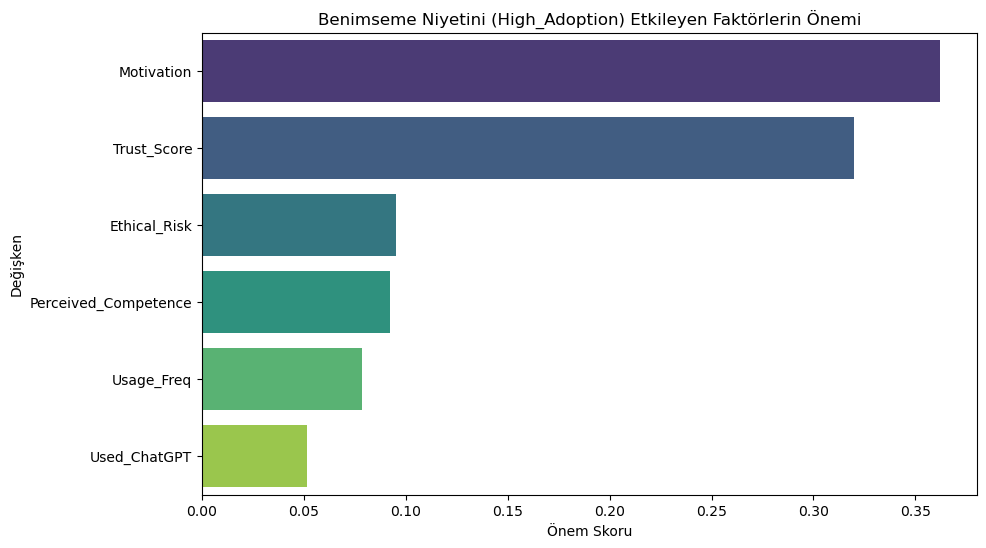

In [46]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Benimseme Niyetini (High_Adoption) Etkileyen Faktörlerin Önemi')
plt.xlabel('Önem Skoru')
plt.ylabel('Değişken')
plt.savefig("outputs/feature_importance.png")
plt.show()

In [ ]:
def get_user_input():
    print("\n--- YENİ KULLANICI ANKETİ (1-5 arası skor giriniz) ---")
    try:
        trust = int(input("1. Güven Puanınız (Trust_Score, 1-5): "))
        risk = int(input("2. Etik Risk Algınız (Ethical_Risk, 1-5): "))
        motivation = int(input("3. Motivasyon Düzeyiniz (Motivation, 1-5): "))
        competence = int(input("4. Algılanan Yeterliliğiniz (Perceived_Competence, 1-5): "))
        usage = int(input("5. Kullanım Sıklığınız (Usage_Freq, 1-5): "))
        chatgpt = int(input("6. ChatGPT Kullandı mı? (1=Evet, 0=Hayır): "))
    except ValueError:
        print("HATA: Lütfen sadece tam sayı giriniz.")
        return None

    # Veri setinizin eğitim sırasında gördüğü KESİN SÜTUN SIRASI
    feature_columns = ['Trust_Score', 'Ethical_Risk', 'Motivation', 'Perceived_Competence', 'Usage_Freq', 'Used_ChatGPT']     
    # Girdileri listeye çeviriyoruz
    input_values = [trust, risk, motivation, competence, usage, chatgpt]
    
    # Sütunları ve sırayı garanti ederek DataFrame oluşturma
    # Bu, ValueError hatasını önleyen kritik adımdır.
    return pd.DataFrame([input_values], columns=feature_columns)

In [48]:
def analyze_new_user(user_data_df):
    if user_data_df is None:
        return

    # a) Veriyi Ölçekleme (fit değil, sadece transform!)
    # X_scaled'ı eğitirken kullandığımız scaler objesini kullanıyoruz.
    X_new_scaled = scaler.transform(user_data_df)
    
    # b) Sınıflandırma (Benimseme Tahmini)
    adoption_prediction = rf_model.predict(X_new_scaled)[0] # Tahmin edilen sınıf (0 veya 1)
    adoption_proba = rf_model.predict_proba(X_new_scaled)[0][1] # Yüksek Niyet olasılığı

    # c) Kümeleme (Kullanıcı Tipi Ataması)
    cluster_assignment = kmeans.predict(X_new_scaled)[0]
    
    # d) Terminal Raporu
    print("\n" + "="*60)
    print("           ✨ ANLIK BENİMSEME ANALİZ RAPORU ✨")
    print("="*60)
    
    # --- Benimseme Tahmini Sonucu ---
    if adoption_prediction == 1:
        print(f"🎯 BENİMSEME TAHMİNİ: Yüksek Potansiyel (Olasılık: {adoption_proba:.2%})")
    else:
        print(f"🎯 BENİMSEME TAHMİNİ: Düşük Potansiyel (Olasılık: {1 - adoption_proba:.2%})")

    # --- Küme Ataması ve Öneri ---
    print("-" * 60)
    print(f"🧠 ATANAN KULLANICI TİPİ: Küme {cluster_assignment}")
    
    # Uygulamanın Öneri Mantığı (Örnek Kurallar)
    if user_data_df['Motivation'].iloc[0] < 3:
        print("💡 ONBOARDING ÖNERİSİ: Motivasyon düşüklüğü tespit edildi. YZ'nin mesleki faydalarını gösteren pratik kullanım senaryolarına odaklanın.")
    elif user_data_df['Ethical_Risk'].iloc[0] >= 4 and user_data_df['Trust_Score'].iloc[0] < 3:
        print("💡 ONBOARDING ÖNERİSİ: Yüksek Risk Algısı ve Düşük Güven. 'YZ Etik Kuralları ve Veri Güvenliği' eğitimi önceliklidir.")
    else:
        print("💡 ONBOARDING ÖNERİSİ: Başarılı başlangıç! İleri düzey 'Prompt Mühendisliği' modülüne yönlendiriliyorsunuz.")
        
    print("="*60)

In [55]:
# KESİN ÇALIŞTIRMA KOMUTU VE SÜTUN SIRALAMASI

# 1. Eğitim sırasında kullanılan kesin sütun sırasını tanımlama:
FEATURE_ORDER = ['Trust_Score', 'Ethical_Risk', 'Motivation', 'Perceived_Competence', 'Usage_Freq', 'Used_ChatGPT']

# 2. Kullanıcıdan girdi alma
user_data = get_user_input()

# 3. HATA DÜZELTME: DataFrame'in sütunlarını, modelin beklediği sıraya zorlama
# Bu, hatayı çözen ana adımdır.
if user_data is not None:
    user_data_fixed = user_data[FEATURE_ORDER]
    analyze_new_user(user_data_fixed)


--- YENİ KULLANICI ANKETİ (1-5 arası skor giriniz) ---


ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.
